<a href="https://colab.research.google.com/github/my612/Quantamania/blob/main/quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install qiskit_optimization qiskit_algorithms
!pip install dimod
!pip install dwave-ocean-sdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.6/158.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.7/103.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.5/225.5 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.0 MB/s eta 0:00:00


In [9]:
from dwave.system import DWaveSampler, EmbeddingComposite
from dwave.samplers import SimulatedAnnealingSampler
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from dimod import BinaryQuadraticModel

In [10]:
def TSP_as_ILP(dist_matrix, print_model = False):


  mod = QuadraticProgram("TSP")

  num_cities = len(dist_matrix)

  for i in range(num_cities):
      for j in range(num_cities):
          if i != j:
              mod.binary_var(f"x_{i}_{j}")
  for i in range(num_cities):
      mod.linear_constraint(linear={f"x_{i}_{j}": 1 for j in range(num_cities) if i != j}, sense='==', rhs=1, name=f'out_{i}')
      mod.linear_constraint(linear={f"x_{j}_{i}": 1 for j in range(num_cities) if i != j}, sense='==', rhs=1, name=f'in_{i}')
  t = {}
  for i in range(num_cities):
      t[i] = mod.integer_var(lowerbound=0, upperbound=num_cities-1, name=f't_{i}')
  for i in range(1, num_cities):  # t_0 is fixed to 0, so start from i=1
      for j in range(1, num_cities):  # Ensure i != j
          if i != j:
              mod.linear_constraint(
                  linear={f"t_{j}": 1, f"t_{i}": -1, f"x_{i}_{j}": -(num_cities - 1)},
                  sense='>=',
                  rhs=1 - (num_cities - 1),
                  name=f"subtour_{i}_{j}"
              )
  obj = {}
  for i in range(num_cities):
    for j in range(num_cities):
        if i != j:
            obj[f"x_{i}_{j}"] = dist_matrix[i][j]
  mod.minimize(linear=obj)
  print(mod.prettyprint())
  return mod


In [11]:
dist_matrix = [
    [0, 2, 9, 10, 7],
    [2, 0, 6, 4, 3],
    [9, 6, 0, 8, 12],
    [10, 4, 8, 0, 5],
    [7, 3, 12, 5, 0]
]

model = TSP_as_ILP(dist_matrix, print_model=True)

Problem name: TSP

Minimize
  2*x_0_1 + 9*x_0_2 + 10*x_0_3 + 7*x_0_4 + 2*x_1_0 + 6*x_1_2 + 4*x_1_3 + 3*x_1_4
  + 9*x_2_0 + 6*x_2_1 + 8*x_2_3 + 12*x_2_4 + 10*x_3_0 + 4*x_3_1 + 8*x_3_2
  + 5*x_3_4 + 7*x_4_0 + 3*x_4_1 + 12*x_4_2 + 5*x_4_3

Subject to
  Linear constraints (22)
    x_0_1 + x_0_2 + x_0_3 + x_0_4 == 1  'out_0'
    x_1_0 + x_2_0 + x_3_0 + x_4_0 == 1  'in_0'
    x_1_0 + x_1_2 + x_1_3 + x_1_4 == 1  'out_1'
    x_0_1 + x_2_1 + x_3_1 + x_4_1 == 1  'in_1'
    x_2_0 + x_2_1 + x_2_3 + x_2_4 == 1  'out_2'
    x_0_2 + x_1_2 + x_3_2 + x_4_2 == 1  'in_2'
    x_3_0 + x_3_1 + x_3_2 + x_3_4 == 1  'out_3'
    x_0_3 + x_1_3 + x_2_3 + x_4_3 == 1  'in_3'
    x_4_0 + x_4_1 + x_4_2 + x_4_3 == 1  'out_4'
    x_0_4 + x_1_4 + x_2_4 + x_3_4 == 1  'in_4'
    -t_1 + t_2 - 4*x_1_2 >= -3  'subtour_1_2'
    -t_1 + t_3 - 4*x_1_3 >= -3  'subtour_1_3'
    -t_1 + t_4 - 4*x_1_4 >= -3  'subtour_1_4'
    t_1 - t_2 - 4*x_2_1 >= -3  'subtour_2_1'
    -t_2 + t_3 - 4*x_2_3 >= -3  'subtour_2_3'
    -t_2 + t_4 - 4*x_2

In [ ]:
qubo = QuadraticProgramToQubo(penalty=100000).convert(model) #Qiskit's quadratic program to Qiskit's QUBO structure


In [ ]:
variable_names = qubo.variables # Save Variables name to map them later

In [ ]:
sampler = SimulatedAnnealingSampler() # D-Wave Quantuam Sampler

In [ ]:
#Break Down the Qiskit QUBO to its components
qubo_dict = qubo.objective.quadratic.to_dict()
linear = qubo.objective.linear.to_dict()
offset = qubo.objective.constant

#Convert To D-Wave BQM
bqm = BinaryQuadraticModel(linear, qubo_dict, offset, 'BINARY')
# qubo, offset = bqm.to_qubo()
sampleset = sampler.sample(bqm, num_reads=1000)
best_solution = sampleset.first.sample

In [ ]:
# Map integer keys to variable names
variable_mapping = {i: name for i, name in enumerate(variable_names)}
print("Variable Mapping:", variable_mapping)

# Example: Convert best_solution (integer keys) to variable names
best_solution_with_names = {variable_mapping[key]: value for key, value in best_solution.items() if key in variable_mapping}
print("Best Solution with Variable Names:", best_solution_with_names)

Variable Mapping: {0: <Variable: x_0_1 (binary)>, 1: <Variable: x_0_2 (binary)>, 2: <Variable: x_0_3 (binary)>, 3: <Variable: x_0_4 (binary)>, 4: <Variable: x_1_0 (binary)>, 5: <Variable: x_1_2 (binary)>, 6: <Variable: x_1_3 (binary)>, 7: <Variable: x_1_4 (binary)>, 8: <Variable: x_2_0 (binary)>, 9: <Variable: x_2_1 (binary)>, 10: <Variable: x_2_3 (binary)>, 11: <Variable: x_2_4 (binary)>, 12: <Variable: x_3_0 (binary)>, 13: <Variable: x_3_1 (binary)>, 14: <Variable: x_3_2 (binary)>, 15: <Variable: x_3_4 (binary)>, 16: <Variable: x_4_0 (binary)>, 17: <Variable: x_4_1 (binary)>, 18: <Variable: x_4_2 (binary)>, 19: <Variable: x_4_3 (binary)>, 20: <Variable: t_0@0 (binary)>, 21: <Variable: t_0@1 (binary)>, 22: <Variable: t_0@2 (binary)>, 23: <Variable: t_1@0 (binary)>, 24: <Variable: t_1@1 (binary)>, 25: <Variable: t_1@2 (binary)>, 26: <Variable: t_2@0 (binary)>, 27: <Variable: t_2@1 (binary)>, 28: <Variable: t_2@2 (binary)>, 29: <Variable: t_3@0 (binary)>, 30: <Variable: t_3@1 (binary)>,

In [ ]:
# Precompute active edges
active_edges = []
for var, value in best_solution_with_names.items():
    if value == 1 and var.name.startswith("x_"):  # Ensure it's an edge variable
        parts = var.name.split("_")  # Split the variable name into parts
        i = int(parts[1])       # Extract i
        j = int(parts[2])       # Extract j
        active_edges.append((i, j))
print("Active Edges:", active_edges)
sum = 0
for edge in active_edges:
  sum += dist_matrix[edge[0]][edge[1]]
print(sum)

Active Edges: [(0, 1), (1, 4), (2, 0), (3, 2), (4, 3)]
27


In [ ]:


# Construct the route using active edges
route = []
num_cities = len(dist_matrix)

# Start at city 0 (or any other starting city)
current_city = 0
route.append(current_city)

# Use a set to track visited cities for faster lookups
visited = set([current_city])

# Iterate to find the next city in the route
while len(route) < num_cities:
    for (i, j) in active_edges:
        if i == current_city and j not in visited:
            route.append(j)
            visited.add(j)
            current_city = j
            break

# Ensure the route is a cycle by returning to the starting city
route.append(route[0])

print("Optimal Route:", route)


Optimal Route: [0, 1, 4, 3, 2, 0]


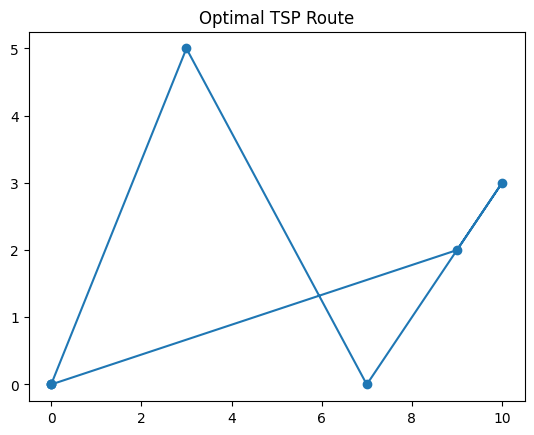

In [ ]:
import matplotlib.pyplot as plt

# Coordinates of cities (for visualization)
city_coords = [
    (0, 0), (3, 5), (9, 2), (10, 3), (7, 0)
]

# Plot the route
x = [city_coords[i][0] for i in route]
y = [city_coords[i][1] for i in route]
x.append(x[0])  # Return to the starting city
y.append(y[0])

plt.plot(x, y, marker='o')
plt.title("Optimal TSP Route")
plt.show()

In [13]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# define the solver to have the exact solution
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(model)
print(result)

ValueError: 71 is too many qubits to convert to a matrix